In [143]:
import pandas as pd
from time import time
import numpy as np
from tqdm import tqdm
import os
import netCDF4 as nc
from progressbar import progressbar
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel
import datetime
from matplotlib import pyplot as plt, rcParams
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib
from scipy.ndimage import gaussian_filter
import xarray as xr
import random
from scipy.interpolate import LinearNDInterpolator
from itertools import product
from scipy.signal import savgol_filter
tqdm.pandas()

from matplotlib import pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import numpy as np
from matplotlib.patches import Rectangle
from random import random

%matplotlib inline

In [4]:
def weighted_time_series_analysis(cygnss_df, smap_df, area, moving_window=2, interval=10, plot=True,
                                  area_name=None, save=None, error_bar_scale=10):
    
    cygnss_df = filter_cygnss_df(cygnss_df, area)
    smap_df = filter_cygnss_df(smap_df, area)
    
    first_day = cygnss_df['day_of_year'].min()
    last_day = cygnss_df['day_of_year'].max()
    
    surface_ref = {}
    surface_ref_std = {}
    soil_moisture = {}
    soil_moisture_std = {}
    
    for day in progressbar(np.arange(first_day, last_day - moving_window, moving_window)):
        # Filter CYGNSS
        current_cygnss = filter_cygnss_day(cygnss_df, day, day + interval)
        
        # Filter SMAP
        current_smap = filter_smap_day(smap_df, day*24, (day + interval)*24)
        
        # current_sr = current_cygnss.apply(lambda row: row.sr*row.w, axis=1).sum() / current_cygnss['w'].sum()
        # current_sr_std = np.sqrt(current_cygnss.apply(lambda row: (row.sr - current_sr)**2, axis=1).sum() / (len(current_cygnss) - 1))
        current_sr = np.sum(np.multiply(current_cygnss['sr'], current_cygnss['w'])) / current_cygnss['w'].sum()        
        current_sr_std = np.sqrt(np.sum(np.multiply((current_cygnss['sr'] - current_sr), (current_cygnss['sr'] - current_sr)))/ (len(current_cygnss) - 1))
        
        if len(current_smap) > 0:
            current_sm = current_smap['smap_sm'].mean()
            current_sm_std = current_smap['smap_sm'].std()
        else:
            current_sm = 0
            current_sm_std = 0
        
        surface_ref[day] = current_sr
        surface_ref_std[day] = current_sr_std
        soil_moisture[day] = current_sm
        soil_moisture_std[day] = current_sm_std
    
    if plot:
        
        error_bar_top = []
        error_bar_bottom = []
        
        for i in range(len(list(surface_ref.values()))):
            error_bar_top.append(list(surface_ref.values())[i] + list(surface_ref_std.values())[i]/error_bar_scale)
            error_bar_bottom.append(list(surface_ref.values())[i] - list(surface_ref_std.values())[i]/error_bar_scale)
        
        fig = plt.figure(figsize=(20, 6))
        ax = plt.axes()
        ax.grid()
        
        
        ax.plot(surface_ref.keys(), surface_ref.values(), color="red", marker="o")
        ax.fill_between(surface_ref_std.keys(), error_bar_top, error_bar_bottom, alpha=.2, linewidth=0, color='red')
        label_size = 20
        ax.set_xlabel("Day after 1st of Jan 2019", fontsize=label_size)
        ax.set_ylabel("SR [dB]", color="red", fontsize=label_size)
        

        ax2 = ax.twinx()
        ax2.grid(False)
        ax2.plot(soil_moisture.keys(), soil_moisture.values(), color="blue", marker="o")
        ax2.set_ylabel("SM [cm^3/cm^3]", color="blue", fontsize=label_size)
        ax.legend(['Surface Reflectivity (SR)', 'std SR/' + str(error_bar_scale)], loc=2)
        ax2.legend(['Soil Moisture (SM)'], loc=3)
        
        if area_name is not None:
            plt.title(area_name + " Correlation: " + str(round(pd.Series(surface_ref.values()).corr(pd.Series(soil_moisture.values())), 3)), fontsize=22)
            if save is not None:
                plt.savefig('/Users/vegardhaneberg/Desktop/Plots Master/Time Series/' + str(area_name) + '.png', format='png')
        else:
            plt.title("Correlation: " + str(round(pd.Series(surface_ref.values()).corr(pd.Series(soil_moisture.values())), 3)), fontsize=18)
            if save is not None:
                random_num = lambda: random.randint(0, 255)
                random_name = '%02X%02X%02X' % (random_num(), random_num(), random_num())
                plt.savefig('/Users/vegardhaneberg/Desktop/Plots Master/Time Series/Without Name' + random_name + '.png', format='png')
        
        plt.show()
        
    return surface_ref, surface_ref_std, soil_moisture, soil_moisture_std

In [207]:
# Functions

def filter_cygnss_df(df: pd.DataFrame, area: dict) -> pd.DataFrame:
    if 'sp_lat' in df.columns:
        new_df = df[df['sp_lat'] <= area['north']]
        new_df = new_df[new_df['sp_lat'] >= area['south']]
        new_df = new_df[new_df['sp_lon'] >= area['west']]
        new_df = new_df[new_df['sp_lon'] <= area['east']]
    else:
        new_df = df[df['lat'] <= area['north']]
        new_df = new_df[new_df['lat'] >= area['south']]
        new_df = new_df[new_df['long'] >= area['west']]
        new_df = new_df[new_df['long'] <= area['east']]

    return new_df


def filter_cygnss_day(df, start_day, end_day):
    filtered_df = df[df['day_of_year'] >= start_day]
    filtered_df = filtered_df[filtered_df['day_of_year'] < end_day]
    
    return filtered_df


def filter_smap_day(df, start_hour, end_hour):
    filtered_df = df[df['time'] >= start_hour]
    filtered_df = filtered_df[filtered_df['time'] < end_hour]
    return filtered_df


def get_smap(path: str, printing=False):
    ds = nc.Dataset(path)
    sm = ds['Soil_Moisture_Retrieval_Data_AM']

    latitudes = []
    longitudes = []
    moistures = []
    times = []
    qfs = []
    roughness = []
    surface_temp = []
    vo = []
    veg_wat_cont = []

    for lat in range(len(sm['latitude'])):
        for long in range(len(sm['longitude'][lat])):
            latitudes.append(sm['latitude'][lat][long])
            longitudes.append(sm['longitude'][lat][long])
            moistures.append(sm['soil_moisture'][lat][long])
            times.append(sm['tb_time_utc'][lat][long])
            qfs.append(sm['retrieval_qual_flag'][lat][long])
            roughness.append(sm['roughness_coefficient'][lat][long])
            surface_temp.append(sm['surface_temperature'][lat][long])
            vo.append(sm['vegetation_opacity'][lat][long])
            veg_wat_cont.append(sm['vegetation_water_content'][lat][long])

    df = pd.DataFrame.from_dict({'lat': latitudes, 'long': longitudes, 'time': times, 'smap_sm': moistures,
                                'retrieval_qfs': qfs, 'surface_roughness': roughness,
                                'surface_temp': surface_temp, 'vegetation_opacity': vo,
                                'vegetation_water_content': veg_wat_cont})

    # Filter out missing values
    smap_df = df[df['smap_sm'] != -9999.0]

    return smap_df


def get_smap_main(root_path: str, years: list, months: list, days: list) -> pd.DataFrame:
    first = True
    sub_dirs = []
    filenames = []

    for dir_name, sub_dir_list, file_list in os.walk(root_path):
        if first:
            sub_dirs = sub_dir_list
            first = False
        else:
            filenames.append(file_list[0])
    
    smap_df = pd.DataFrame()
    
    for i in progressbar(range(len(sub_dirs))):
        current_day = int(filenames[i].split('_')[4][6:8])
        current_month = int(filenames[i].split('_')[4][4:6])
        current_year = int(filenames[i].split('_')[4][:4])
        
        if (current_day in days) and (current_year in years) and (current_month in months):
            current_path = root_path + '/' + sub_dirs[i] + '/' + filenames[i]
            current_df = get_smap(current_path)
            smap_df = smap_df.append(current_df)
    
    return smap_df


def get_era_5(path, area):
    ds = xr.open_dataset(path)
    era_5_df = ds.to_dataframe()
    #MEMORY
    ds = 0
    
    # Can i do this with the meshgrid??
    #era_5_df = era_5_df.dropna()
    
    index_long = era_5_df.index.levels[1]
    index_lat = era_5_df.index.levels[2]
    index_time = era_5_df.index.levels[0]
    rain = era_5_df["pr"].to_numpy()
    
    #MEMORY
    era_5_df = 0
    
    start_time = pd.Timestamp(2020, 1, 1)
    index_time_fixed = []
    for tid in index_time:
        delta = tid - start_time
        index_time_fixed.append(delta.days)
        
    #MEMORY
    index_time = 0

    lon, lat, time = np.meshgrid(index_long, index_lat, index_time_fixed, indexing='ij')
    
    #MEMORY 
    index_long = 0
    index_lat = 0
    index_time_fixed = 0
    index_date_fixed = 0
    
    lon = lon.flatten()
    lat = lat.flatten()
    time = time.flatten()
    
    df = pd.DataFrame({'long': lon, 'lat': lat, "day_of_year" : time, 'rain': rain})
    
    df = filter_cygnss_df(df, area)
    
    return df


# Main time series for loop
def time_series_analysis(cygnss_df, smap_df, area, moving_window=2, interval=10, use_median=True, 
                         plot=True, area_name=None, save=None, use_smoothening=False, sigma=None,
                         error_bar_scale=10):
    
    cygnss_df = filter_cygnss_df(cygnss_df, area)
    smap_df = filter_cygnss_df(smap_df, area)
    
    first_day = cygnss_df['day_of_year'].min()
    last_day = cygnss_df['day_of_year'].max()
    
    surface_ref = {}
    surface_ref_std = {}
    soil_moisture = {}
    soil_moisture_std = {}
    
    for day in np.arange(first_day, last_day - moving_window, moving_window):
        # Filter CYGNSS
        current_cygnss = filter_cygnss_day(cygnss_df, day, day + interval)
        if use_smoothening:
            current_cygnss = grid_box(current_cygnss, 'sr', True)
            current_cygnss = smoothening(current_cygnss, area, sigma, 'sr')
        
        # Filter SMAP
        current_smap = filter_smap_day(smap_df, day*24, (day + interval)*24)
        
        if use_median:
            current_sr = current_cygnss['sr'].median()
            current_sr_std = current_cygnss['sr'].mad()
        else:
            current_sr = current_cygnss['sr'].mean()
            current_sr_std = current_cygnss['sr'].std()
        
        if len(current_smap) > 0:
            current_sm = current_smap['smap_sm'].mean()
            current_sm_std = current_smap['smap_sm'].std()
        else:
            # print('EMPTY SMAP from day:', day, 'to day:', day + interval)
            current_sm = np.mean(list(soil_moisture.values()))
            current_sm_std = 0
        
        surface_ref[day] = current_sr
        surface_ref_std[day] = current_sr_std
        soil_moisture[day] = current_sm
        soil_moisture_std[day] = current_sm_std
    
    if plot:
        
        error_bar_top = []
        error_bar_bottom = []
        
        for i in range(len(list(surface_ref.values()))):
            error_bar_top.append(list(surface_ref.values())[i] + list(surface_ref_std.values())[i]/error_bar_scale)
            error_bar_bottom.append(list(surface_ref.values())[i] - list(surface_ref_std.values())[i]/error_bar_scale)
        
        fig = plt.figure(figsize=(20, 6))
        ax = plt.axes()
        ax.grid()
        
        
        ax.plot(surface_ref.keys(), surface_ref.values(), color="red", marker="o")
        ax.fill_between(surface_ref_std.keys(), error_bar_top, error_bar_bottom, alpha=.2, linewidth=0, color='red')
        label_size = 20
        ax.set_xlabel("Day after 1st of Jan 2019", fontsize=label_size)
        ax.set_ylabel("SR [dB]", color="red", fontsize=label_size)
        

        ax2 = ax.twinx()
        ax2.grid(False)
        ax2.plot(soil_moisture.keys(), soil_moisture.values(), color="blue", marker="o")
        ax2.set_ylabel("SM [cm^3/cm^3]", color="blue", fontsize=label_size)
        ax.legend(['Surface Reflectivity (SR)', 'std SR/' + str(error_bar_scale)], loc=2)
        ax2.legend(['Soil Moisture (SM)'], loc=3)
        
        if area_name is not None:
            plt.title(area_name + " Correlation: " + str(round(pd.Series(surface_ref.values()).corr(pd.Series(soil_moisture.values())), 3)), fontsize=22)
            if save is not None:
                plt.savefig('/Users/vegardhaneberg/Desktop/Plots Master/Time Series/' + str(area_name) + '.png', format='png')
        else:
            plt.title("Correlation: " + str(round(pd.Series(surface_ref.values()).corr(pd.Series(soil_moisture.values())), 3)), fontsize=18)
            if save is not None:
                random_num = lambda: random.randint(0, 255)
                random_name = '%02X%02X%02X' % (random_num(), random_num(), random_num())
                plt.savefig('/Users/vegardhaneberg/Desktop/Plots Master/Time Series/Without Name' + random_name + '.png', format='png')
        
        plt.show()
        
    return surface_ref, surface_ref_std, soil_moisture, soil_moisture_std


# Main time series for loop with rain
def time_series_analysis_with_rain(cygnss_df, smap_df, era5_df, area, moving_window=2, interval=10, use_median=True, plot=True):
    
    cygnss_df = filter_cygnss_df(cygnss_df, area)
    smap_df = filter_cygnss_df(smap_df, area)
    era5_df = filter_cygnss_df(era5_df, area)
    # convert from mm rain each day to mm rain each hour
    era5_df['rain'] = era5_df['rain'].apply(lambda rain: rain/24)
    
    first_day = cygnss_df['day_of_year'].min()
    last_day = cygnss_df['day_of_year'].max()
    
    surface_ref = {}
    surface_ref_std = {}
    soil_moisture = {}
    soil_moisture_std = {}
    rain = {}
    rain_std = {}
    
    for day in progressbar(np.arange(first_day, last_day - moving_window, moving_window)):
        current_cygnss = filter_cygnss_day(cygnss_df, day, day + interval)
        current_smap = filter_smap_day(smap_df, day*24, (day + interval)*24)
        current_era5 = filter_cygnss_day(era5_df, day, day + interval)
        
        if use_median:
            current_sr = current_cygnss['sr'].median()
            current_sr_std = current_cygnss['sr'].mad()
        else:
            current_sr = current_cygnss['sr'].mean()
            current_sr_std = current_cygnss['sr'].std()
        
        current_sm = current_smap['smap_sm'].mean()
        current_sm_std = current_smap['smap_sm'].std()
        
        current_rain = current_era5['rain'].mean()
        current_rain_std = current_era5['rain'].std()
        
        surface_ref[day] = current_sr
        surface_ref_std[day] = current_sr_std
        soil_moisture[day] = current_sm
        soil_moisture_std[day] = current_sm_std
        rain[day] = current_rain
        rain_std[day] = current_rain_std
        
    if plot:
        fig = plt.figure(figsize=(20, 4))
        ax = plt.axes()

        # ax.errorbar(x=list(sr.keys()), y=list(sr.values()), yerr=sr_std.values(), color="red", marker="o")
        ax.plot(surface_ref.keys(), surface_ref.values(), color="red", marker="o")
        ax.set_xlabel("Day after 1st of Jan 2020", fontsize=14)
        ax.set_ylabel("SR [dB]", color="red", fontsize=14)

        ax2 = ax.twinx()
        ax2.grid(False)
        ax2.bar(rain.keys(), rain.values(), color="blue")
        ax2.set_ylim([min(list(rain.values())), max(list(rain.values())) + min(list(rain.values()))])
        ax2.invert_yaxis()
        ax2.set_ylabel("precipitation [mm/hour]", color="blue", fontsize=14)
        plt.title("Correlation: " + str(round(pd.Series(surface_ref.values()).corr(pd.Series(rain.values())), 3)), fontsize=18)
        plt.show()
        
    return surface_ref, surface_ref_std, soil_moisture, soil_moisture_std, rain, rain_std


def smoothening(df: pd.DataFrame, area: dict, sigma: float, target_value='sr') -> pd.DataFrame:
    """
    Assumes that the surface reflectivity values have been grid boxed on a spatial resolution of 
    0.1 by 0.1 degrees, and that there is no missing values. 
    """
    df = df.sort_values(['lat', 'long'], ascending=(False, True))
    lats = np.arange(area['north'], area['south'] - 0.05, -0.1)
    lats = np.around(lats, 1)
    longs = np.arange(area['west'], area['east'] + 0.05, 0.1)
    longs = np.around(longs, 1)
    
    all_coords = list(product(lats, longs))
    
    existing_lats = np.around(list(df['lat']), 1)
    existing_longs = np.around(list(df['long']), 1)
    existing_cords = list(zip(existing_lats, existing_longs))
    
    missing_coords = []
    for coord in all_coords:
        if coord not in existing_cords:
            missing_coords.append(coord)
    
    missing_lats = []
    missing_longs = []
    missing_sr = []
    
    if len(missing_coords) > 0:
        inter_func = interpolate(df, 'sr')
        
        for coord in missing_coords:
            missing_lats.append(coord[0])
            missing_longs.append(coord[1])
            missing_sr.append(inter_func(coord[0], coord[1]))

    df = df.append(pd.DataFrame.from_dict({'lat': missing_lats, 'long': missing_longs, 'sr': missing_sr}))
    df = df.astype({'sr': float})
    # df['sr'] = pd.to_numeric(df['sr'])
    
    target_values = np.array(df[target_value]).reshape(len(lats), len(longs))
    target_values = gaussian_filter(target_values, sigma=sigma)
    target_values = target_values.flatten()
    df[target_value] = target_values

    return df


def interpolate(df: pd.DataFrame, target_value, lat_name='lat', long_name='long') -> LinearNDInterpolator:
    coordinates = list(zip(list(df[lat_name]), list(df[long_name])))
    target = df[target_value]
    interpolation_function = LinearNDInterpolator(coordinates, target)
    return interpolation_function


def round_nearest(x, a):
    return round(x / a) * a


def grid_box(df, target_value='sr', use_median=True):
    df['lat'] = df['lat'].apply(lambda x: round_nearest(x, 0.1))
    df['long'] = df['long'].apply(lambda x: round_nearest(x, 0.1))
    
    if use_median:
        df = df.groupby(['long', 'lat'], as_index=False)[target_value].median()
    else:
        df = df.groupby(['long', 'lat'], as_index=False)[target_value].mean()
    
    return df


def conv(t):
    try:
        return pd.Timestamp(t)
    except:
        return pd.Timestamp(t.split('.')[0] + '.000Z')


def convert_time(df: pd.DataFrame, reference_time=None) -> pd.DataFrame:
    if reference_time is None:
        ref_date = pd.Timestamp('2019-01-01T00:00:00.000Z')
    else:
        ref_date = pd.Timestamp(reference_time)

    df['time'] = df['time'].apply(lambda t: conv(t))
    df['time'] = df['time'].apply(lambda t: (t - ref_date).days * 24 + (t - ref_date).seconds / 3600)
    return df

def convert_day_of_year(hours):
    start = datetime.datetime(2019, 1, 1)
    return (start + datetime.timedelta(hours=hours)).day


def filter_inc_angle(df, min_angle, max_angle):
    filtered_df = df[df.sp_inc_angle <= max_angle]
    filtered_df = filtered_df[filtered_df.sp_inc_angle >= min_angle]
    return filtered_df


In [6]:
# Choose area (IranPakistan for the month of July in 2019, 2020 and 2021)

def get_month_from_doy(dayOfYear, year):
    return datetime.datetime.strptime('{} {}'.format(dayOfYear, year),'%j %Y').month


def preparation_function(path_to_cygnss_folder):
    
    years = [2019, 2020, 2021]
    sd_cygnss_df = pd.DataFrame()
    
    for year in years:
        file_name = 'CYGNSS' + str(year) + '-withQFs-[-22-117--27-122].csv'
        tmp_df = pd.read_csv(path_to_cygnss_folder + file_name)
        tmp_df['month'] = tmp_df.apply(lambda row: get_month_from_doy(int(row.day_of_year), year), axis=1)
        sd_cygnss_df = sd_cygnss_df.append(tmp_df, ignore_index=True)
        
    sd_cygnss_df = sd_cygnss_df[sd_cygnss_df['month'] == 7]
    
    lat_min = round(sd_cygnss_df['sp_lat'].min())
    lat_max = round(sd_cygnss_df['sp_lat'].max())
    lon_min = round(sd_cygnss_df['sp_lon'].min())
    lon_max = round(sd_cygnss_df['sp_lon'].max())
    
    grid_box_interval = 0.2
    interval_range = 5

    lat_north_values = []
    lat_south_values = []
    lon_west_values = []
    lon_east_values = []
    grid_box_range_values = []

    inc_start_values = []
    inc_end_values = []
    inc_range_values = []

    n_obs_values = []
    sr_sd_values = []

    for lat_north in np.arange(lat_max, lat_min, -grid_box_interval):
        for lon_west in np.arange(lon_min, lon_max, grid_box_interval):

            lat_south = lat_north - grid_box_interval
            lon_east = lon_west + grid_box_interval
            grid_box_df = filter_cygnss_df(sd_cygnss_df, {'north': lat_north, 'south': lat_south, 'west': lon_west, 'east': lon_east})

            for x_0 in range(0, (56+(10-interval_range))):
                x_1 = x_0 + interval_range
                inc_angle_df = filter_inc_angle(grid_box_df, x_0, x_1)

                if inc_angle_df.shape[0] > 0:
                    sr_sd = np.std(list(inc_angle_df['sr']))
                    sr_sd_values.append(sr_sd)
                else:
                    sr_sd_values.append(np.nan)

                lat_north_values.append(lat_north)
                lat_south_values.append(lat_south)
                lon_west_values.append(lon_west)
                lon_east_values.append(lon_east)
                grid_box_range_values.append(grid_box_interval)

                inc_start_values.append(x_0)
                inc_end_values.append(x_1)
                inc_range_values.append(interval_range)

                n_obs_values.append(inc_angle_df.shape[0])

    sr_sd_dict = {'north' : lat_north_values, 'west' : lon_west_values, 'south' : lat_south_values, 'east' : lon_east_values,
                  'grid_box_size' : grid_box_range_values, 'inc_start' : inc_start_values, 'inc_end' : inc_end_values,
                  'inc_range' : inc_range_values, 'n_obs' : n_obs_values, 'sr_sd' : sr_sd_values}

    sr_sd_df = pd.DataFrame(sr_sd_dict)

    #Drop NaN values
    sr_sd_df = sr_sd_df.dropna()
    
    sr_std_dict = {}
    
    for x_0 in range(0, 61):
        sd_values = list(sr_sd_df['sr_sd'][sr_sd_df['inc_start'] == x_0])
        sd_median = np.median(sd_values)
        
        sr_std_dict[x_0] = sd_median
        
    return sr_std_dict


def overall_time_series_plot(correlations):
    special_regions = [max(correlations, key=correlations.get), min(correlations, key=correlations.get)]

    fig, ax = plt.subplots(figsize=(9, 9))

    plt.xlim([selected_area['west'], selected_area['east']])
    plt.ylim([selected_area['south'], selected_area['north']])


    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))

    # Scaling opacity values
    max_corr = max(list(correlations.values()))
    min_corr = min(list(correlations.values()))
    diff_corr = max_corr - min_corr

    correlations_scaled = {}

    for key in correlations:
        correlations_scaled[key] = (correlations[key] - min_corr)/diff_corr


    index = 0
    for x in np.arange(selected_area['west'], selected_area['east'] - 0.05, 0.5):
        for y in np.arange(selected_area['south'], selected_area['north'] - 0.05, 0.5):
            if (x, y) not in special_regions:
                current_corr = round(correlations[(x, y)], 3)
                ax.text(x + 0.25, y + 0.25, current_corr, fontsize=14, verticalalignment='center', horizontalalignment='center')
                ax.add_patch(Rectangle((x, y), 0.5, 0.5, color='green', alpha=correlations_scaled[(x, y)]))
            else:
                # ax.text(x + 0.25, y + 0.25, alphabet[index], fontsize=14, verticalalignment='center', horizontalalignment='center', weight='bold')
                if correlations[(x, y)] == max_corr:
                    ax.text(x + 0.25, y + 0.25, round(correlations[(x, y)], 3), fontsize=14, verticalalignment='center', horizontalalignment='center')
                    ax.add_patch(Rectangle((x, y), 0.5, 0.5, color='blue', alpha=0.8))
                else:
                    ax.text(x + 0.25, y + 0.25, round(correlations[(x, y)], 3), fontsize=14, verticalalignment='center', horizontalalignment='center')
                    ax.add_patch(Rectangle((x, y), 0.5, 0.5, color='red'))
                index = index + 1


    plt.title(selected_area_string + ' Overview Correlation Between \nCYGNSS and SMAP for 2019 - 2021', fontsize=30)

    ax.set_xlabel('Longitude [degree]', fontsize=20)
    ax.set_ylabel('Latitude [degree]', fontsize=20)

    plt.tight_layout()

    plt.grid(color='black', linewidth=1)
    plt.show()


In [7]:
############################################################################
############################ Start Analysis ################################
############################################################################

africa = {'north': -7, 'south': -12, 'west': 23, 'east': 28}
brazil = {'north': -5, 'south': -10, 'west': -42, 'east': -37}
australia = {'north': -22, 'south': -27, 'west': 117, 'east': 122}
iran = {'north': 31, 'south': 26, 'west': 59, 'east': 64}
india = {'north': 24, 'south': 19, 'west': 80, 'east': 85}

iran_flood = 'center (lat, long): (27.5, 59) 2 by 2 degrees'

cygnss_path_africa = '/Volumes/Seagate Ekstern Hardisk/Processed Files/-7-23--12-28/CYGNSS 2019 to 2021'
cygnss_path_brazil = '/Volumes/Seagate Ekstern Hardisk/Processed Files/-5--42--10--37/CYGNSS 2019 to 2021'
cygnss_path_australia = '/Volumes/Seagate Ekstern Hardisk/Processed Files/-22-117--27-122/CYGNSS 2019 to 2021'
cygnss_path_iran = '/Volumes/Seagate Ekstern Hardisk/Processed Files/31-59-26-64/CYGNSS 2019 to 2021'
cygnss_path_india = '/Volumes/Seagate Ekstern Hardisk/Processed Files/24-80-19-85/CYGNSS 2019 to 2021'

smap_root_path_africa = '/Volumes/Seagate Ekstern Hardisk/Processed Files/-7-23--12-28/SMAP2020-withQFs-[-7-23--12-28].csv'
smap_root_path_brazil = '/Volumes/Seagate Ekstern Hardisk/Processed Files/-5--42--10--37/SMAP2020-withQFs-[-5--42--10--37].csv'
smap_root_path_australia = '/Volumes/Seagate Ekstern Hardisk/Processed Files/-22-117--27-122/SMAP2020-withQFs-[-22-117--27-122].csv'
smap_root_path_iran = '/Volumes/Seagate Ekstern Hardisk/Processed Files/31-59-26-64/SMAP2020-withQFs-[31-59-26-64].csv'
smap_root_path_india = '/Volumes/Seagate Ekstern Hardisk/Processed Files/24-80-19-85/SMAP2020-withQFs-[24-80-19-85].csv'

selected_era5_path = '/Users/vegardhaneberg/Desktop/Masters Thesis/Code/Master/Data/ERA5/global_2020_rain_v6'

moving_window = 2  # Number of days to be skipped between each data point in the time series
interval = 10 # The number of days to be averaged in each data point in the time series


In [ ]:
# Read CYGNSS
# raw_cygnss_df = pd.read_csv(selected_cygnss_path)[['sp_lat', 'sp_lon', 'day_of_year', 'sp_inc_angle', 'sr']].rename(columns={'sp_lat': 'lat', 'sp_lon': 'long'})

In [73]:
ref_date_2019 = '2019-01-01T00:00:00.000Z'
path_name = '/Users/vegardhaneberg/Desktop/Prosessed SMAP 3 years/Ball test run/india 2019-2021.csv'

smap_df = pd.read_csv(path_name)
converted_time_df = convert_time(smap_df)

test__df.to_csv('/Users/vegardhaneberg/Desktop/Prosessed SMAP 3 years/India 2019-2021.csv')

EMPTY SMAP from day: 169 to day: 179
EMPTY SMAP from day: 171 to day: 181
EMPTY SMAP from day: 173 to day: 183
EMPTY SMAP from day: 175 to day: 185
EMPTY SMAP from day: 177 to day: 187
EMPTY SMAP from day: 179 to day: 189
EMPTY SMAP from day: 181 to day: 191
EMPTY SMAP from day: 183 to day: 193
EMPTY SMAP from day: 185 to day: 195
EMPTY SMAP from day: 187 to day: 197
EMPTY SMAP from day: 189 to day: 199
EMPTY SMAP from day: 191 to day: 201
EMPTY SMAP from day: 193 to day: 203


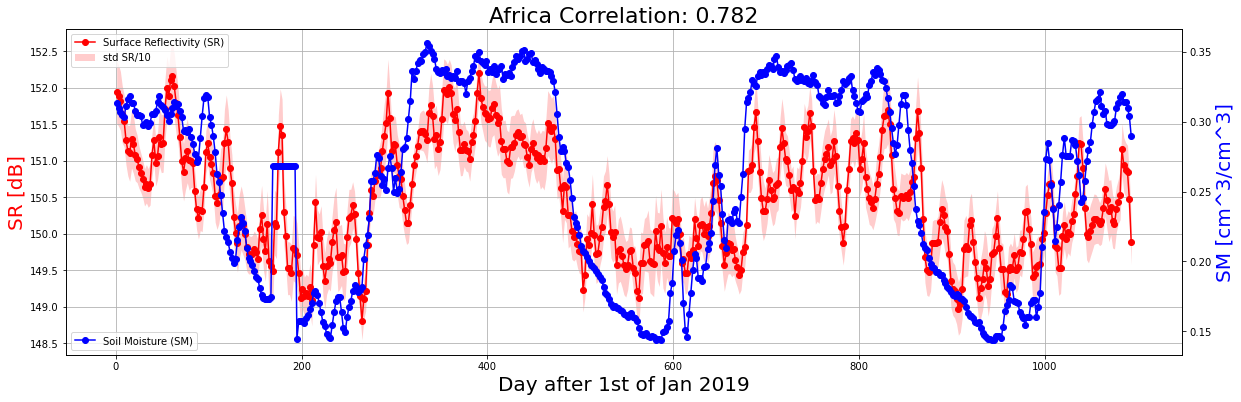

In [45]:
selected_area_string = 'Africa'
selected_area = africa
selected_cygnss_path = cygnss_path_africa
selected_smap_path = smap_root_path_africa
selected_smap_path = '/Users/vegardhaneberg/Desktop/Prosessed SMAP 3 years/Africa 2019-2020.csv'

# Read CYGNSS from all years
raw_cygnss_df = pd.read_csv(selected_cygnss_path)[['sp_lat', 'sp_lon', 'day_of_year', 'sp_inc_angle', 'sr']].rename(columns={'sp_lat': 'lat', 'sp_lon': 'long'})

# Read SMAP from all years
raw_smap_df = pd.read_csv(selected_smap_path)
# raw_smap_df['time'] = raw_smap_df['time'] + 24*365

"""
TIME SERIES FOR 0.1 x 0.1 DEGREES
for lat in np.arange(selected_area['south'] + 0.5, selected_area['north'] - 0.5 + 0.05, 1):
    for long in np.arange(selected_area['west'] + 0.5, selected_area['east'] - 0.5 + 0.05, 1):
        current_area = {'north': round(lat, 1) + 0.5, 
                        'south': round(lat, 1) - 0.5, 
                        'west': round(long, 1) - 0.5, 
                        'east': round(long, 1) + 0.5}
        current_area_string = 'Center Point: (' + str(round(lat, 1)) + ', ' + str(round(long, 1)) + ')'
        
        current_cygnss = filter_cygnss_df(raw_cygnss_df, current_area)
        current_smap = filter_cygnss_df(raw_smap_df, current_area)
        
        sr, sr_std, sm, sm_std, = time_series_analysis(current_cygnss,
                                                       current_smap,
                                                       current_area,
                                                       moving_window,
                                                       interval,
                                                       True,
                                                       True,
                                                       current_area_string)
"""   

"""
NORMAL TIME SERIES WITH SMOOTHENING
sigma = 1.5
sr, sr_std, sm, sm_std, = time_series_analysis(raw_cygnss_df, 
                                               raw_smap_df, 
                                               selected_area,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string + ' with Smoothening Sigma = ' + str(sigma),
                                               save='/Users/vegardhaneberg/Desktop/Plots Master/Time Series/',
                                               use_smoothening=True,
                                               sigma=sigma,
                                               error_bar_scale=5)
"""

sr, sr_std, sm, sm_std, = time_series_analysis(raw_cygnss_df, 
                                               raw_smap_df, 
                                               selected_area,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string,
                                               save='/Users/vegardhaneberg/Desktop/Plots Master/Time Series/',
                                               error_bar_scale=10)




In [41]:
start = 193*24
end = 203*24
print('start:', start)
print('end:', end)

raw_smap_df[(raw_smap_df['time'] > start) & (raw_smap_df['time'] < end)]

start: 4632
end: 4872


0

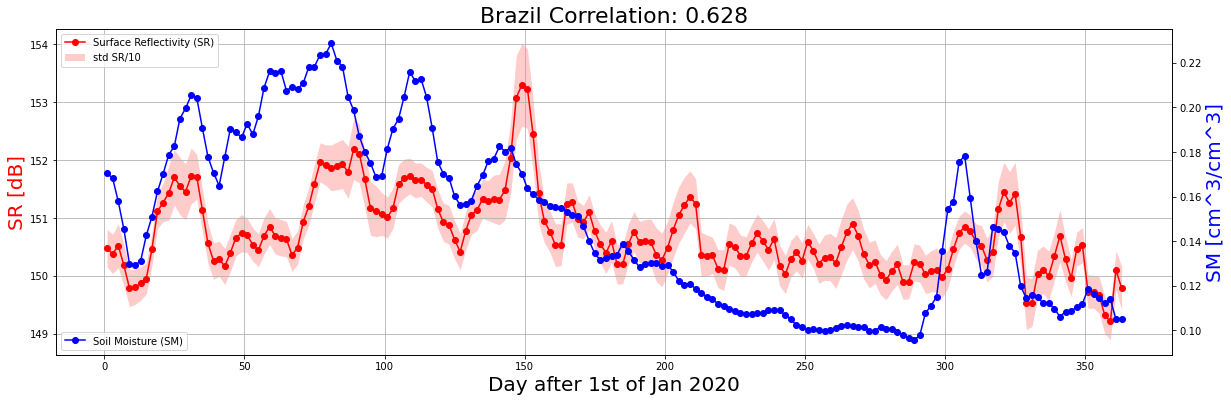

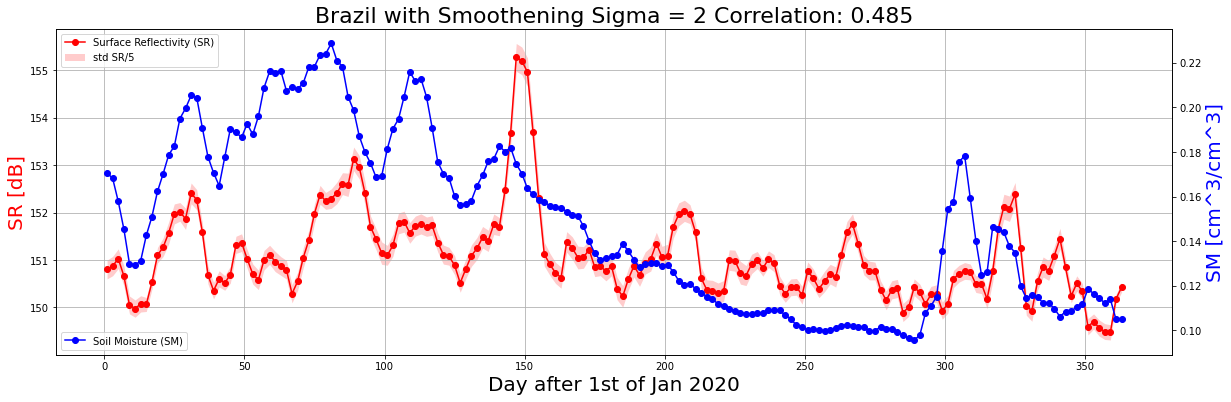

In [47]:
# Main Brazil Analysis
selected_area_string = 'Brazil'
selected_area = {'north': -5, 'south': -10, 'west': -42, 'east': -37}
selected_cygnss_path = '/Volumes/Seagate Ekstern Hardisk/Processed Files/-5--42--10--37/CYGNSS 2019 to 2021'
selected_smap_path = '/Users/vegardhaneberg/Desktop/Prosessed SMAP 3 years/Brazil 2019-2021.csv'

raw_cygnss_df = pd.read_csv(selected_cygnss_path)[['sp_lat', 'sp_lon', 'day_of_year', 'sp_inc_angle', 'sr']].rename(columns={'sp_lat': 'lat', 'sp_lon': 'long'})
raw_smap_df = pd.read_csv(selected_smap_path)[['lat', 'long', 'time', 'smap_sm']]

correlations = {}
# Time series for each 0.5 x 0.5 degrees area
for lat in np.arange(selected_area['south'], selected_area['north'] - 0.5 + 0.05, 0.5):
    for long in np.arange(selected_area['west'], selected_area['east'] - 0.5 + 0.05, 0.5):
        current_area = {'north': round(lat, 1) + 0.5, 
                        'south': round(lat, 1), 
                        'west': round(long, 1), 
                        'east': round(long, 1) + 0.5}
        current_area_string = 'Bottom left corner: (' + str(round(lat, 1)) + ', ' + str(round(long, 1)) + ')'
        
        current_cygnss = filter_cygnss_df(raw_cygnss_df, current_area)
        current_smap = filter_cygnss_df(raw_smap_df, current_area)
        
        sr, sr_std, sm, sm_std, = time_series_analysis(current_cygnss,
                                                       current_smap,
                                                       current_area,
                                                       moving_window,
                                                       interval,
                                                       True,
                                                       False,
                                                       current_area_string)
        correlations[(long, lat)] = pd.Series(sr).corr(pd.Series(sm))

overall_time_series_plot(correlations)

# Overall time series
sr, sr_std, sm, sm_std, = time_series_analysis(raw_cygnss_df, 
                                               raw_smap_df, 
                                               selected_area,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string,
                                               save='/Users/vegardhaneberg/Desktop/Plots Master/Time Series/')
# Time series best region
best_region_corner = max(correlations, key=correlations.get)
print('Best region bottom left corner:', best_region_corner)
best_region = {'north': best_region_corner[1] + 0.5, 
               'south': best_region_corner[1], 
               'west': best_region_corner[0], 
               'east': best_region_corner[0] + 0.5}
sr, sr_std, sm, sm_std, = time_series_analysis(filter_cygnss_df(raw_cygnss_df, best_region), 
                                               filter_cygnss_df(raw_smap_df, best_region), 
                                               best_region,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string,
                                               save='/Users/vegardhaneberg/Desktop/Plots Master/Time Series/')
# Time series worst region
worst_region_corner = min(correlations, key=correlations.get)
print('Worst region bottom left corner:', worst_region_corner)
worst_region = {'north': worst_region_corner[1] + 0.5, 
               'south': worst_region_corner[1], 
               'west': worst_region_corner[0], 
               'east': worst_region_corner[0] + 0.5}
sr, sr_std, sm, sm_std, = time_series_analysis(filter_cygnss_df(raw_cygnss_df, worst_region), 
                                               filter_cygnss_df(raw_smap_df, worst_region), 
                                               worst_region,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string,
                                               save='/Users/vegardhaneberg/Desktop/Plots Master/Time Series/')


"""
selected_area_string = 'Brazil'
selected_area = brazil
selected_cygnss_path = cygnss_path_brazil
selected_smap_path = smap_root_path_brazil

sigma = 2

raw_cygnss_df = pd.read_csv(selected_cygnss_path)[['sp_lat', 'sp_lon', 'day_of_year', 'sp_inc_angle', 'sr']].rename(columns={'sp_lat': 'lat', 'sp_lon': 'long'})
raw_smap_df = pd.read_csv(selected_smap_path)


for lat in np.arange(selected_area['south'] + 0.5, selected_area['north'] - 0.5 + 0.05, 1):
    for long in np.arange(selected_area['west'] + 0.5, selected_area['east'] - 0.5 + 0.05, 1):
        current_area = {'north': round(lat, 1) + 0.5, 
                        'south': round(lat, 1) - 0.5, 
                        'west': round(long, 1) - 0.5, 
                        'east': round(long, 1) + 0.5}
        current_area_string = 'Center Point: (' + str(round(lat, 1)) + ', ' + str(round(long, 1)) + ')'
        
        current_cygnss = filter_cygnss_df(raw_cygnss_df, current_area)
        current_smap = filter_cygnss_df(raw_smap_df, current_area)
        
        sr, sr_std, sm, sm_std, = time_series_analysis(current_cygnss,
                                                       current_smap,
                                                       current_area,
                                                       moving_window,
                                                       interval,
                                                       True,
                                                       True,
                                                       current_area_string)


sr, sr_std, sm, sm_std, = time_series_analysis(raw_cygnss_df, 
                                               raw_smap_df, 
                                               selected_area,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string,
                                               save='/Users/vegardhaneberg/Desktop/Plots Master/Time Series/')

sr, sr_std, sm, sm_std, = time_series_analysis(raw_cygnss_df, 
                                               raw_smap_df, 
                                               selected_area,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string + ' with Smoothening Sigma = ' + str(sigma),
                                               save='/Users/vegardhaneberg/Desktop/Plots Master/Time Series/',
                                               use_smoothening=True,
                                               sigma=sigma,
                                               error_bar_scale=5)
"""
print('Average STD Surface Reflectivity:', np.nanmean(np.array(list(sr_std.values()))))


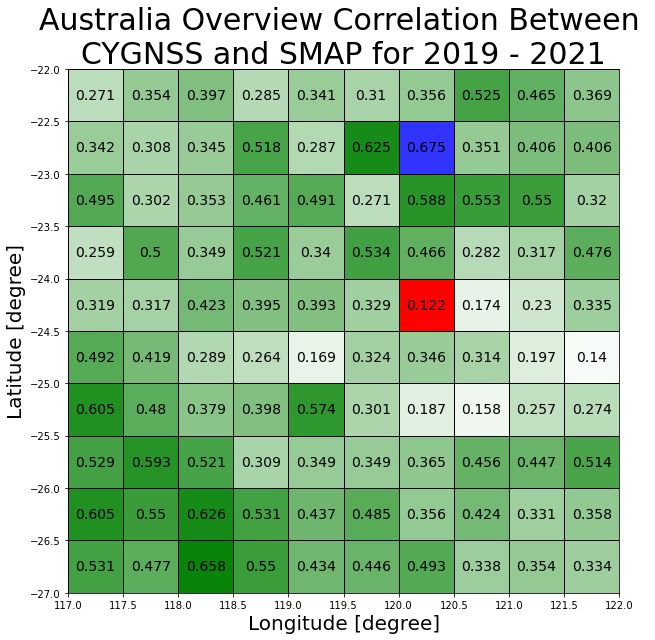

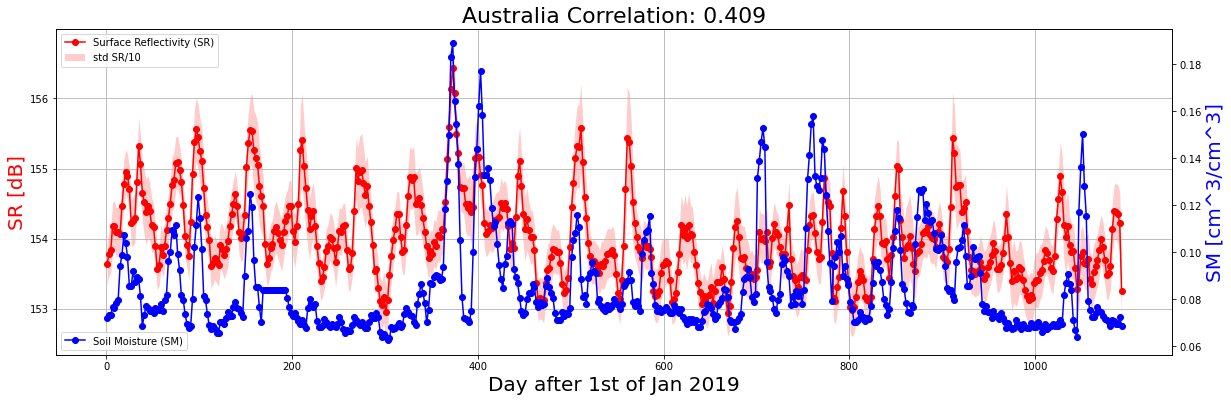

Best region bottom left corner: (120.0, -23.0)


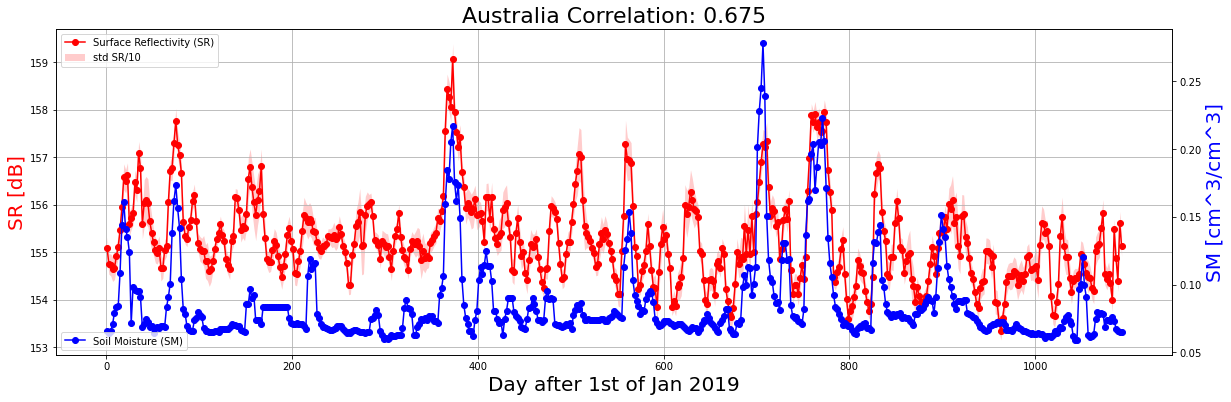

Worst region bottom left corner: (120.0, -24.5)


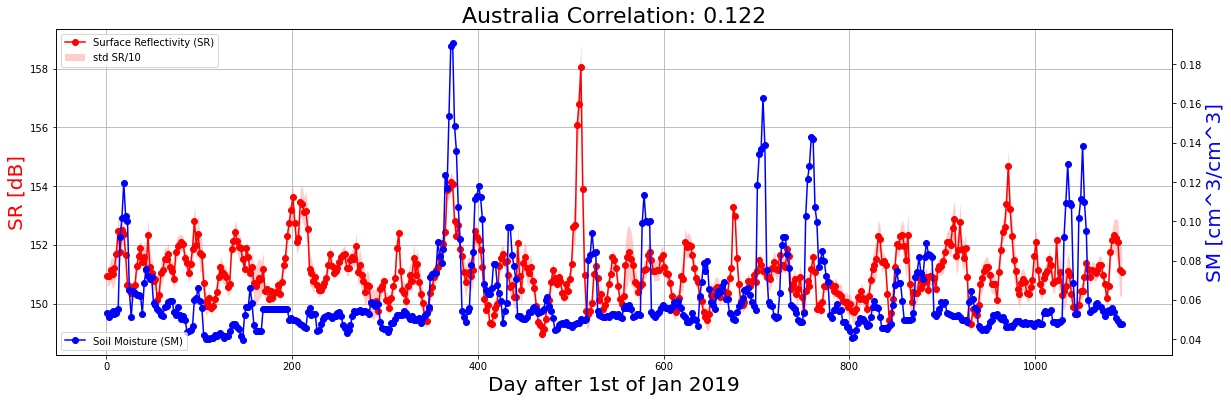

Done
Average STD Surface Reflectivity: 3.6488694808035715


In [192]:
# Main Australia Analysis
selected_area_string = 'Australia'
selected_area = {'north': -22, 'south': -27, 'west': 117, 'east': 122}
selected_cygnss_path = '/Volumes/Seagate Ekstern Hardisk/Processed Files/-22-117--27-122/CYGNSS 2019 to 2021'
selected_smap_path = '/Users/vegardhaneberg/Desktop/Prosessed SMAP 3 years/Australia 2019-2021.csv'

raw_cygnss_df = pd.read_csv(selected_cygnss_path)[['sp_lat', 'sp_lon', 'day_of_year', 'sp_inc_angle', 'sr']].rename(columns={'sp_lat': 'lat', 'sp_lon': 'long'})
raw_smap_df = pd.read_csv(selected_smap_path)[['lat', 'long', 'time', 'smap_sm']]

correlations = {}
# Time series for each 0.5 x 0.5 degrees area
for lat in np.arange(selected_area['south'], selected_area['north'] - 0.5 + 0.05, 0.5):
    for long in np.arange(selected_area['west'], selected_area['east'] - 0.5 + 0.05, 0.5):
        current_area = {'north': round(lat, 1) + 0.5, 
                        'south': round(lat, 1), 
                        'west': round(long, 1), 
                        'east': round(long, 1) + 0.5}
        current_area_string = 'Bottom left corner: (' + str(round(lat, 1)) + ', ' + str(round(long, 1)) + ')'
        
        current_cygnss = filter_cygnss_df(raw_cygnss_df, current_area)
        current_smap = filter_cygnss_df(raw_smap_df, current_area)
        
        sr, sr_std, sm, sm_std, = time_series_analysis(current_cygnss,
                                                       current_smap,
                                                       current_area,
                                                       moving_window,
                                                       interval,
                                                       True,
                                                       False,
                                                       current_area_string)
        correlations[(long, lat)] = pd.Series(sr).corr(pd.Series(sm))

overall_time_series_plot(correlations)

# Overall time series
sr, sr_std, sm, sm_std, = time_series_analysis(raw_cygnss_df, 
                                               raw_smap_df, 
                                               selected_area,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string,
                                               save='/Users/vegardhaneberg/Desktop/Plots Master/Time Series/')
# Time series best region
best_region_corner = max(correlations, key=correlations.get)
print('Best region bottom left corner:', best_region_corner)
best_region = {'north': best_region_corner[1] + 0.5, 
               'south': best_region_corner[1], 
               'west': best_region_corner[0], 
               'east': best_region_corner[0] + 0.5}
sr, sr_std, sm, sm_std, = time_series_analysis(filter_cygnss_df(raw_cygnss_df, best_region), 
                                               filter_cygnss_df(raw_smap_df, best_region), 
                                               best_region,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string,
                                               save='/Users/vegardhaneberg/Desktop/Plots Master/Time Series/')
# Time series worst region
worst_region_corner = min(correlations, key=correlations.get)
print('Worst region bottom left corner:', worst_region_corner)
worst_region = {'north': worst_region_corner[1] + 0.5, 
               'south': worst_region_corner[1], 
               'west': worst_region_corner[0], 
               'east': worst_region_corner[0] + 0.5}
sr, sr_std, sm, sm_std, = time_series_analysis(filter_cygnss_df(raw_cygnss_df, worst_region), 
                                               filter_cygnss_df(raw_smap_df, worst_region), 
                                               worst_region,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string,
                                               save='/Users/vegardhaneberg/Desktop/Plots Master/Time Series/')

print('Done')

"""
sigma = 2
sr, sr_std, sm, sm_std, = time_series_analysis(raw_cygnss_df, 
                                               raw_smap_df, 
                                               selected_area,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string + ' with Smoothening Sigma = ' + str(sigma),
                                               save='/Users/vegardhaneberg/Desktop/Plots Master/Time Series/',
                                               use_smoothening=True,
                                               sigma=sigma,
                                               error_bar_scale=5)

selected_area_string = 'Australia'
selected_area = australia
selected_cygnss_path = cygnss_path_australia
selected_smap_path = smap_root_path_australia

sigma = 2

raw_cygnss_df = pd.read_csv(selected_cygnss_path)[['sp_lat', 'sp_lon', 'day_of_year', 'sp_inc_angle', 'sr']].rename(columns={'sp_lat': 'lat', 'sp_lon': 'long'})
raw_smap_df = pd.read_csv(selected_smap_path)


for lat in np.arange(selected_area['south'] + 0.5, selected_area['north'] - 0.5 + 0.05, 1):
    for long in np.arange(selected_area['west'] + 0.5, selected_area['east'] - 0.5 + 0.05, 1):
        current_area = {'north': round(lat, 1) + 0.5, 
                        'south': round(lat, 1) - 0.5, 
                        'west': round(long, 1) - 0.5, 
                        'east': round(long, 1) + 0.5}
        current_area_string = 'Center Point: (' + str(round(lat, 1)) + ', ' + str(round(long, 1)) + ')'
        
        current_cygnss = filter_cygnss_df(raw_cygnss_df, current_area)
        current_smap = filter_cygnss_df(raw_smap_df, current_area)
        
        sr, sr_std, sm, sm_std, = time_series_analysis(current_cygnss,
                                                       current_smap,
                                                       current_area,
                                                       moving_window,
                                                       interval,
                                                       True,
                                                       True,
                                                       current_area_string)


sr, sr_std, sm, sm_std, = time_series_analysis(raw_cygnss_df, 
                                               raw_smap_df, 
                                               selected_area,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string,
                                               save='/Users/vegardhaneberg/Desktop/Plots Master/Time Series/')
"""
"""
sr, sr_std, sm, sm_std, = time_series_analysis(raw_cygnss_df, 
                                               raw_smap_df, 
                                               selected_area,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string + ' with Smoothening Sigma = ' + str(sigma),
                                               save='/Users/vegardhaneberg/Desktop/Plots Master/Time Series/',
                                               use_smoothening=True,
                                               sigma=sigma,
                                               error_bar_scale=5)
"""

print('Average STD Surface Reflectivity:', np.nanmean(np.array(list(sr_std.values()))))


EMPTY SMAP from day: 171 to day: 181
EMPTY SMAP from day: 173 to day: 183
EMPTY SMAP from day: 175 to day: 185
EMPTY SMAP from day: 177 to day: 187
EMPTY SMAP from day: 179 to day: 189
EMPTY SMAP from day: 181 to day: 191
EMPTY SMAP from day: 183 to day: 193
EMPTY SMAP from day: 185 to day: 195
EMPTY SMAP from day: 187 to day: 197
EMPTY SMAP from day: 189 to day: 199
EMPTY SMAP from day: 191 to day: 201
EMPTY SMAP from day: 193 to day: 203
EMPTY SMAP from day: 195 to day: 205


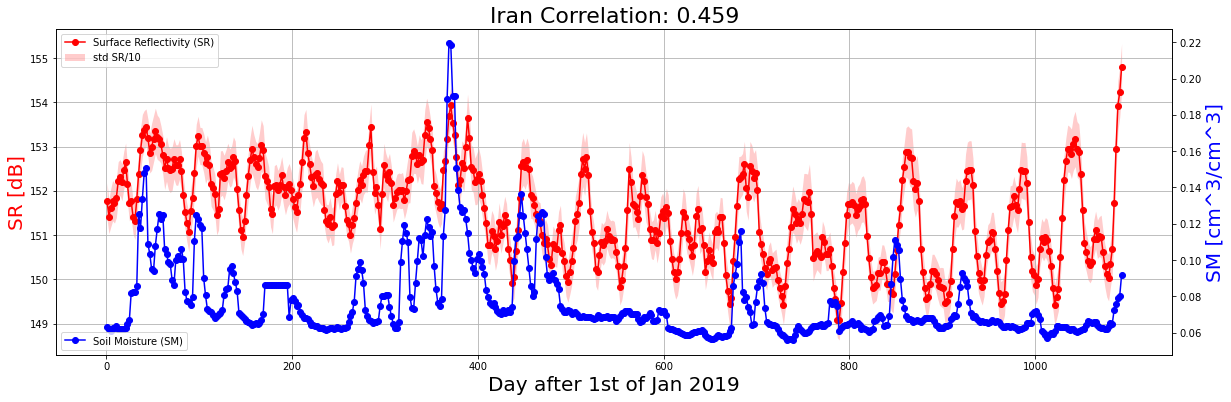

Average STD Surface Reflectivity: 4.733565085137805


In [91]:
selected_area_string = 'Iran'
selected_area = iran
selected_cygnss_path = cygnss_path_iran
selected_smap_path = smap_root_path_iran
selected_smap_path = '/Users/vegardhaneberg/Desktop/Prosessed SMAP 3 years/Iran 2019-2021.csv'

raw_cygnss_df = pd.read_csv(selected_cygnss_path)
raw_smap_df = pd.read_csv(selected_smap_path)

# raw_smap_df['time'] = raw_smap_df['time'] + 24*365

sr, sr_std, sm, sm_std = time_series_analysis(raw_cygnss_df, 
                                               raw_smap_df, 
                                               selected_area,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string,
                                               save='/Users/vegardhaneberg/Desktop/Plots Master/Time Series/',
                                               error_bar_scale=10)

"""
for lat in np.arange(selected_area['south'] + 0.5, selected_area['north'] - 0.5 + 0.05, 1):
    for long in np.arange(selected_area['west'] + 0.5, selected_area['east'] - 0.5 + 0.05, 1):
        current_area = {'north': round(lat, 1) + 0.5, 
                        'south': round(lat, 1) - 0.5, 
                        'west': round(long, 1) - 0.5, 
                        'east': round(long, 1) + 0.5}
        current_area_string = 'Center Point: (' + str(round(lat, 1)) + ', ' + str(round(long, 1)) + ')'
        
        current_cygnss = filter_cygnss_df(raw_cygnss_df, current_area)
        current_smap = filter_cygnss_df(raw_smap_df, current_area)
        
        sr, sr_std, sm, sm_std, = time_series_analysis(current_cygnss,
                                                       current_smap,
                                                       current_area,
                                                       moving_window,
                                                       interval,
                                                       True,
                                                       True,
                                                       current_area_string,
                                                       error_bar_scale=1)
"""
"""
sr, sr_std, sm, sm_std = time_series_analysis(raw_cygnss_df, 
                                               raw_smap_df, 
                                               selected_area,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string + ' with Smoothening Sigma = ' + str(sigma),
                                               save='/Users/vegardhaneberg/Desktop/Plots Master/Time Series/',
                                               use_smoothening=True,
                                               sigma=2,
                                               error_bar_scale=5)
"""

print('Average STD Surface Reflectivity:', np.nanmean(np.array(list(sr_std.values()))))


EMPTY SMAP from day: 171 to day: 181
EMPTY SMAP from day: 176 to day: 186
EMPTY SMAP from day: 181 to day: 191
EMPTY SMAP from day: 186 to day: 196
EMPTY SMAP from day: 191 to day: 201
EMPTY SMAP from day: 196 to day: 206


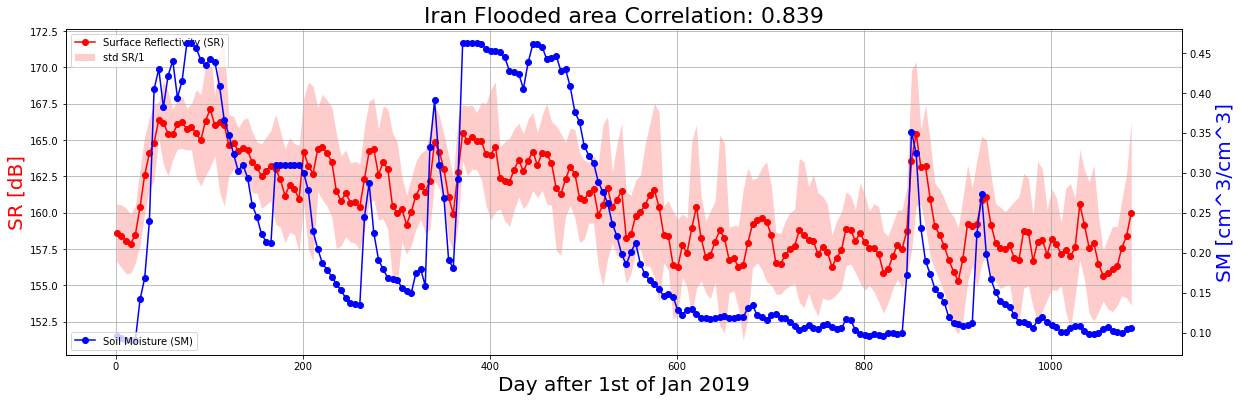

In [93]:
selected_area_string = 'Iran Flooded area'
selected_area = {'north': 27.5, 'south': 27.3, 'west': 58.7, 'east': 59.2}
selected_cygnss_path = cygnss_path_iran
selected_smap_path = smap_root_path_iran
selected_smap_path = '/Users/vegardhaneberg/Desktop/Prosessed SMAP 3 years/Iran 2019-2021.csv'

raw_cygnss_df = pd.read_csv(selected_cygnss_path)
raw_smap_df = pd.read_csv(selected_smap_path)

sr, sr_std, sm, sm_std = time_series_analysis(raw_cygnss_df, 
                                               raw_smap_df, 
                                               selected_area,
                                               5, 
                                               10, 
                                               False, 
                                               True,
                                               selected_area_string,
                                               save='/Users/vegardhaneberg/Desktop/Plots Master/Time Series/',
                                               error_bar_scale=1)

"""
cygnss_df, smap_df, area, moving_window=2, interval=10, use_median=True, 
plot=True, area_name=None, save=None, use_smoothening=False, sigma=None,
error_bar_scale=10)
"""

iran_flood = 'center (lat, long): (27.5, 59) 2 by 2 degrees'





In [204]:
# Initializing weights df for Iran
uncertanty_dict_iran = preparation_function('/Volumes/Seagate Ekstern Hardisk/Processed Files/-22-117--27-122/')

In [206]:
raw_cygnss_df = pd.read_csv(selected_cygnss_path)
raw_cygnss_df = filter_cygnss_day(raw_cygnss_df, 365, 365+366)
raw_cygnss_df['w'] = raw_cygnss_df['sp_inc_angle'].apply(lambda inc: 1/uncertanty_dict_iran[round(inc)] if round(inc) < 61 else 1/uncertanty_dict_iran[60])

test_df = filter_cygnss_day(raw_cygnss_df, 365, 375)
test_df['dummy_weight'] = test_df['w'].apply(lambda w: 1)

current_sr = np.sum(np.multiply(test_df['sr'], test_df['w'])) / test_df['w'].sum()
sr_weight_1 = np.sum(np.multiply(test_df['sr'], test_df['dummy_weight'])) / test_df['dummy_weight'].sum()
sr_mean = test_df['sr'].mean()

print(current_sr)
print(sr_weight_1)
print(sr_mean)

current_sr_std = np.sqrt(np.sum(np.multiply((current_cygnss['sr'] - current_sr), (current_cygnss['sr'] - current_sr)))/ (len(current_cygnss) - 1))

152.96973894911204
153.20883694024212
153.20883694024292


<AxesSubplot:xlabel='sp_inc_angle', ylabel='w1'>

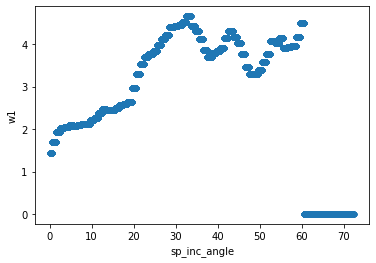

In [202]:
raw_cygnss_df['w1'] = raw_cygnss_df['sp_inc_angle'].apply(lambda inc: uncertanty_dict_iran[round(inc)] if round(inc) < 61 else 0)
raw_cygnss_df.plot.scatter('sp_inc_angle', 'w1', )


100% (182 of 182) |######################| Elapsed Time: 0:00:15 Time:  0:00:15


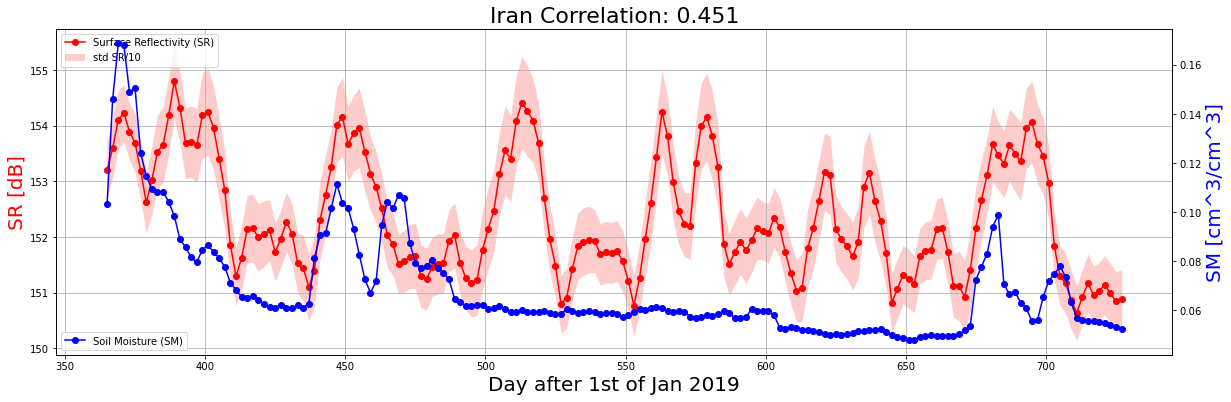

Average STD Surface Reflectivity: 6.210044513796333


In [195]:
############################################################
############## Weightet average time series ################
############################################################

selected_area_string = 'Iran'
selected_area = {'north': 31, 'south': 26, 'west': 59, 'east': 64}
selected_cygnss_path = cygnss_path_iran
selected_smap_path = smap_root_path_iran

sigma = 2

raw_cygnss_df = pd.read_csv(selected_cygnss_path)
raw_cygnss_df = filter_cygnss_day(raw_cygnss_df, 365, 365+366)
raw_cygnss_df['w'] = raw_cygnss_df['sp_inc_angle'].apply(lambda inc: 1/uncertanty_dict_iran[round(inc)] if round(inc) < 61 else 0)
# raw_cygnss_df['w'] = raw_cygnss_df['sp_inc_angle'].apply(lambda inc: 1)

raw_smap_df = pd.read_csv(selected_smap_path)
raw_smap_df['time'] = raw_smap_df['time'] + 24*365


sr, sr_std, sm, sm_std = weighted_time_series_analysis(raw_cygnss_df, 
                                                       raw_smap_df, 
                                                       selected_area, 
                                                       area_name=selected_area_string)
print('Average STD Surface Reflectivity:', np.nanmean(np.array(list(sr_std.values()))))

# weighted_time_series_analysis(cygnss_df, 
#                               smap_df, 
#                               area, 
#                               moving_window=2, 
#                               interval=10, 
#                               plot=True, 
#                               area_name=None, 
#                               save=None, 
#                               error_bar_scale=10)


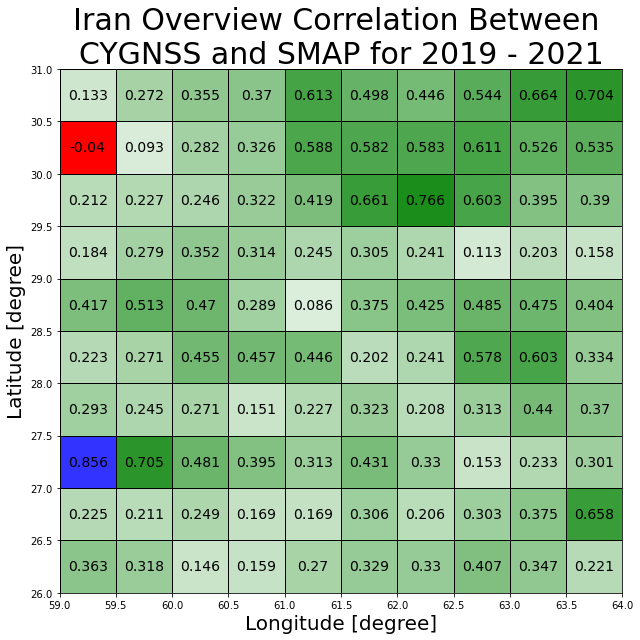

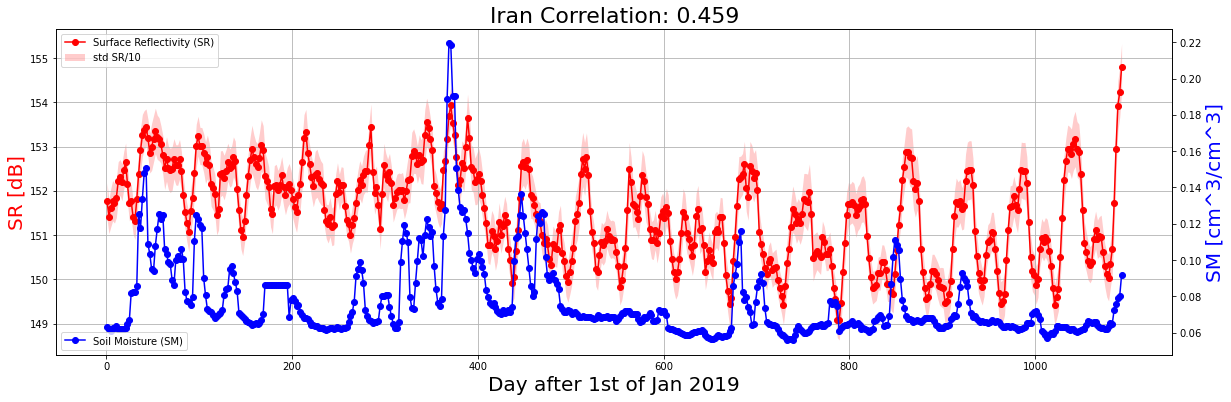

Best region bottom left corner: (59.0, 27.0)


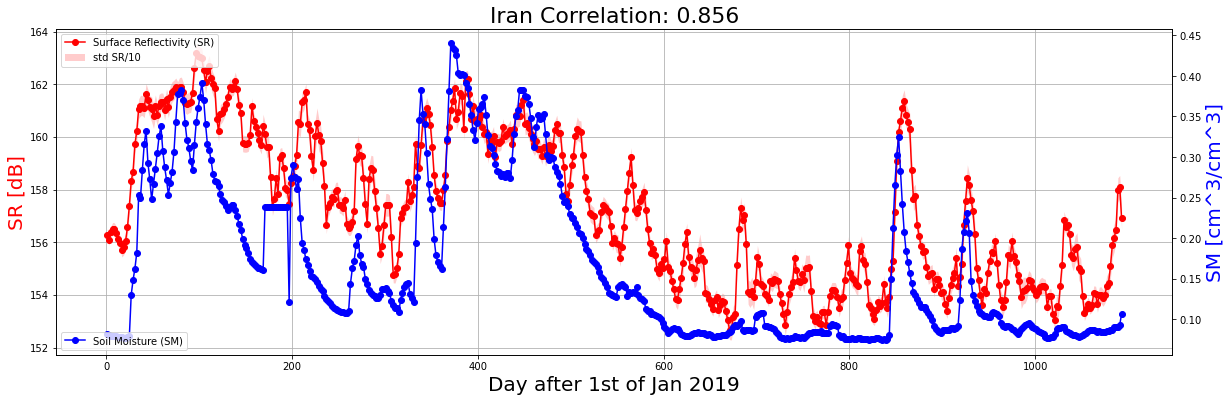

Worst region bottom left corner: (59.0, 30.0)


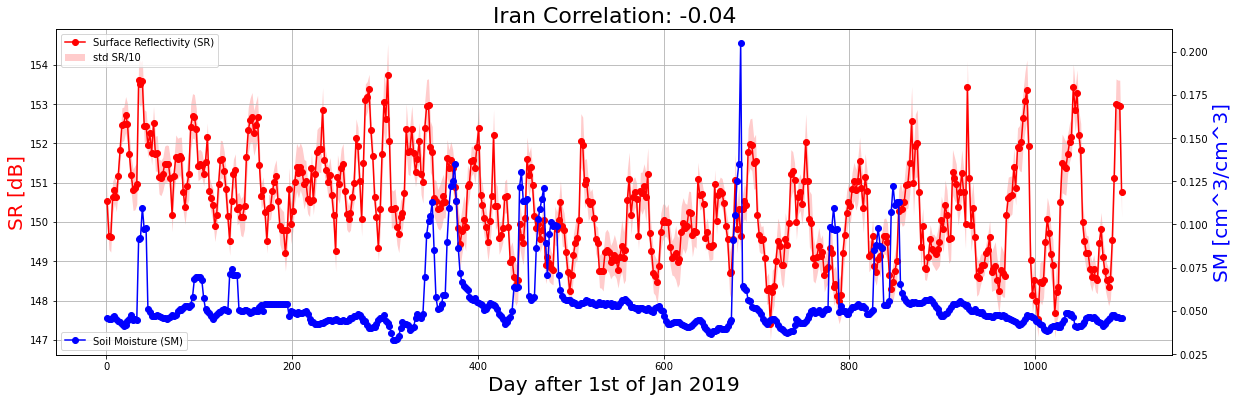

Done


In [175]:
# Main Iran Analysis
selected_area_string = 'Iran'
selected_area = {'north': 31, 'south': 26, 'west': 59, 'east': 64}
selected_cygnss_path = '/Volumes/Seagate Ekstern Hardisk/Processed Files/31-59-26-64/CYGNSS 2019 to 2021'
selected_smap_path = '/Users/vegardhaneberg/Desktop/Prosessed SMAP 3 years/Iran 2019-2021.csv'

raw_cygnss_df = pd.read_csv(selected_cygnss_path)[['sp_lat', 'sp_lon', 'day_of_year', 'sp_inc_angle', 'sr']].rename(columns={'sp_lat': 'lat', 'sp_lon': 'long'})
raw_smap_df = pd.read_csv(selected_smap_path)[['lat', 'long', 'time', 'smap_sm']]

correlations = {}
# Time series for each 0.5 x 0.5 degrees area
for lat in np.arange(selected_area['south'], selected_area['north'] - 0.5 + 0.05, 0.5):
    for long in np.arange(selected_area['west'], selected_area['east'] - 0.5 + 0.05, 0.5):
        current_area = {'north': round(lat, 1) + 0.5, 
                        'south': round(lat, 1), 
                        'west': round(long, 1), 
                        'east': round(long, 1) + 0.5}
        current_area_string = 'Bottom left corner: (' + str(round(lat, 1)) + ', ' + str(round(long, 1)) + ')'
        
        current_cygnss = filter_cygnss_df(raw_cygnss_df, current_area)
        current_smap = filter_cygnss_df(raw_smap_df, current_area)
        
        sr, sr_std, sm, sm_std, = time_series_analysis(current_cygnss,
                                                       current_smap,
                                                       current_area,
                                                       moving_window,
                                                       interval,
                                                       True,
                                                       False,
                                                       current_area_string)
        correlations[(long, lat)] = pd.Series(sr).corr(pd.Series(sm))

overall_time_series_plot(correlations)

# Overall time series
sr, sr_std, sm, sm_std, = time_series_analysis(raw_cygnss_df, 
                                               raw_smap_df, 
                                               selected_area,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string,
                                               save='/Users/vegardhaneberg/Desktop/Plots Master/Time Series/')
# Time series best region
best_region_corner = max(correlations, key=correlations.get)
print('Best region bottom left corner:', best_region_corner)
best_region = {'north': best_region_corner[1] + 0.5, 
               'south': best_region_corner[1], 
               'west': best_region_corner[0], 
               'east': best_region_corner[0] + 0.5}
sr, sr_std, sm, sm_std, = time_series_analysis(filter_cygnss_df(raw_cygnss_df, best_region), 
                                               filter_cygnss_df(raw_smap_df, best_region), 
                                               best_region,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string,
                                               save='/Users/vegardhaneberg/Desktop/Plots Master/Time Series/')
# Time series worst region
worst_region_corner = min(correlations, key=correlations.get)
print('Worst region bottom left corner:', worst_region_corner)
worst_region = {'north': worst_region_corner[1] + 0.5, 
               'south': worst_region_corner[1], 
               'west': worst_region_corner[0], 
               'east': worst_region_corner[0] + 0.5}
sr, sr_std, sm, sm_std, = time_series_analysis(filter_cygnss_df(raw_cygnss_df, worst_region), 
                                               filter_cygnss_df(raw_smap_df, worst_region), 
                                               worst_region,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string,
                                               save='/Users/vegardhaneberg/Desktop/Plots Master/Time Series/')


"""
sigma = 2
sr, sr_std, sm, sm_std, = time_series_analysis(raw_cygnss_df, 
                                               raw_smap_df, 
                                               selected_area,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string + ' with Smoothening Sigma = ' + str(sigma),
                                               save='/Users/vegardhaneberg/Desktop/Plots Master/Time Series/',
                                               use_smoothening=True,
                                               sigma=sigma,
                                               error_bar_scale=5)

"""
print('Done')


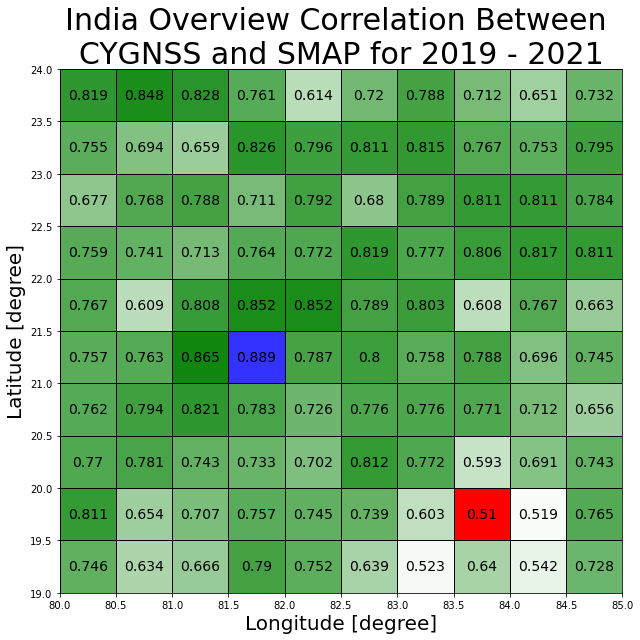

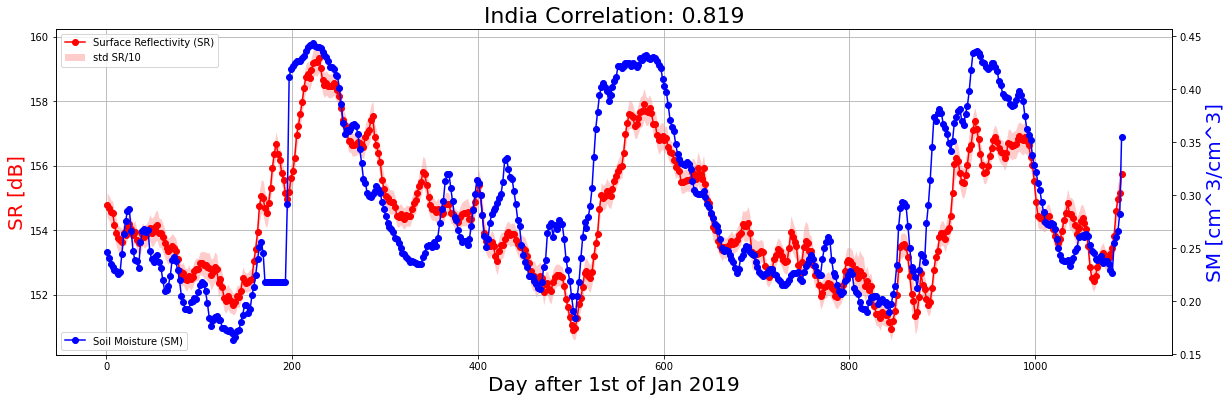

Best region bottom left corner: (81.5, 21.0)


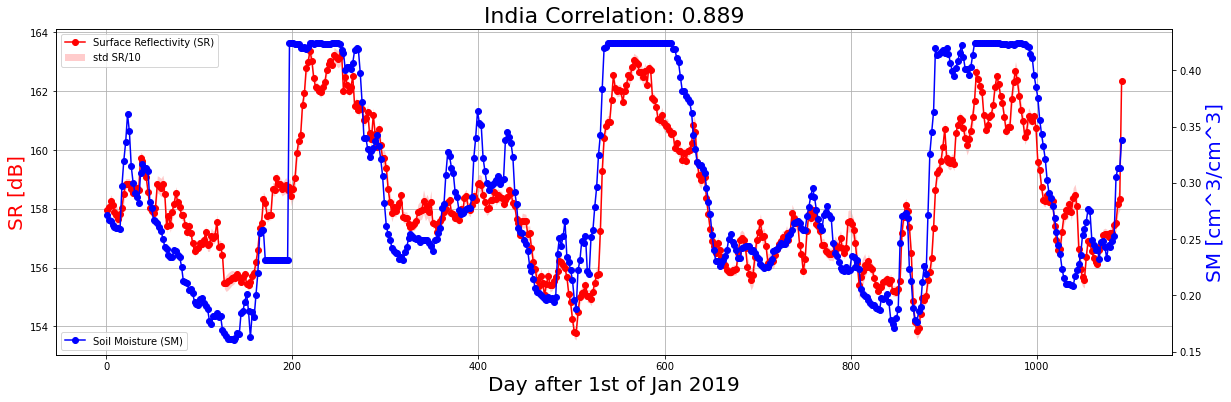

Worst region bottom left corner: (83.5, 19.5)


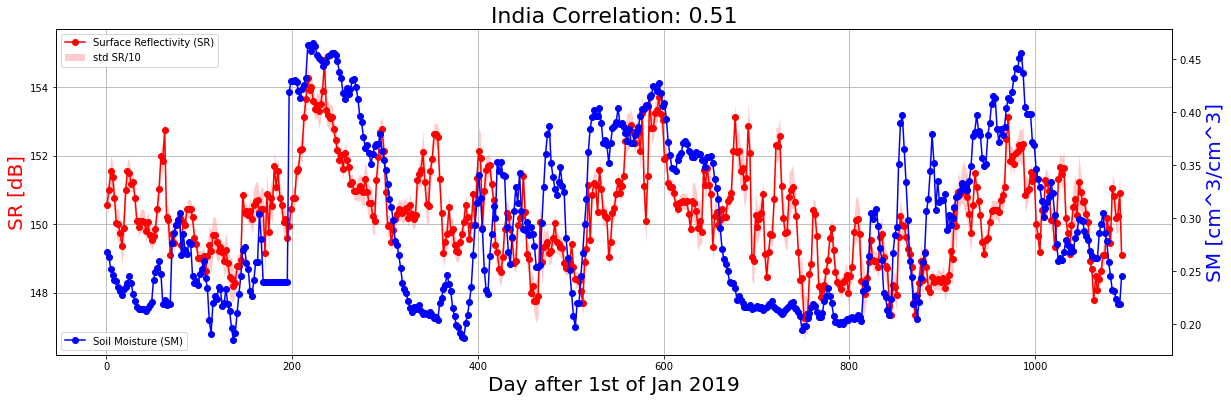

Done


In [191]:
# Main India Analysis
selected_area_string = 'India'
selected_area = {'north': 24, 'south': 19, 'west': 80, 'east': 85}
selected_cygnss_path = '/Volumes/Seagate Ekstern Hardisk/Processed Files/24-80-19-85/CYGNSS 2019 to 2021'
selected_smap_path = '/Users/vegardhaneberg/Desktop/Prosessed SMAP 3 years/India 2019-2021.csv'

raw_cygnss_df = pd.read_csv(selected_cygnss_path)[['sp_lat', 'sp_lon', 'day_of_year', 'sp_inc_angle', 'sr']].rename(columns={'sp_lat': 'lat', 'sp_lon': 'long'})
raw_smap_df = pd.read_csv(selected_smap_path)[['lat', 'long', 'time', 'smap_sm']]

moving_window = 2
interval = 10


correlations = {}
# Time series for each 0.5 x 0.5 degrees area
for lat in np.arange(selected_area['south'], selected_area['north'] - 0.5 + 0.05, 0.5):
    for long in np.arange(selected_area['west'], selected_area['east'] - 0.5 + 0.05, 0.5):
        current_area = {'north': round(lat, 1) + 0.5, 
                        'south': round(lat, 1), 
                        'west': round(long, 1), 
                        'east': round(long, 1) + 0.5}
        current_area_string = 'Bottom left corner: (' + str(round(lat, 1)) + ', ' + str(round(long, 1)) + ')'
        
        current_cygnss = filter_cygnss_df(raw_cygnss_df, current_area)
        current_smap = filter_cygnss_df(raw_smap_df, current_area)
        
        sr, sr_std, sm, sm_std, = time_series_analysis(current_cygnss,
                                                       current_smap,
                                                       current_area,
                                                       moving_window,
                                                       interval,
                                                       True,
                                                       False,
                                                       current_area_string)
        correlations[(long, lat)] = pd.Series(sr).corr(pd.Series(sm))

overall_time_series_plot(correlations)

# Overall time series
sr, sr_std, sm, sm_std, = time_series_analysis(raw_cygnss_df, 
                                               raw_smap_df, 
                                               selected_area,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string,
                                               save='/Users/vegardhaneberg/Desktop/Plots Master/Time Series/')
# Time series best region
best_region_corner = max(correlations, key=correlations.get)
print('Best region bottom left corner:', best_region_corner)
best_region = {'north': best_region_corner[1] + 0.5, 
               'south': best_region_corner[1], 
               'west': best_region_corner[0], 
               'east': best_region_corner[0] + 0.5}
sr, sr_std, sm, sm_std, = time_series_analysis(filter_cygnss_df(raw_cygnss_df, best_region), 
                                               filter_cygnss_df(raw_smap_df, best_region), 
                                               best_region,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string,
                                               save='/Users/vegardhaneberg/Desktop/Plots Master/Time Series/')
# Time series worst region
worst_region_corner = min(correlations, key=correlations.get)
print('Worst region bottom left corner:', worst_region_corner)
worst_region = {'north': worst_region_corner[1] + 0.5, 
               'south': worst_region_corner[1], 
               'west': worst_region_corner[0], 
               'east': worst_region_corner[0] + 0.5}
sr, sr_std, sm, sm_std, = time_series_analysis(filter_cygnss_df(raw_cygnss_df, worst_region), 
                                               filter_cygnss_df(raw_smap_df, worst_region), 
                                               worst_region,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string,
                                               save='/Users/vegardhaneberg/Desktop/Plots Master/Time Series/')


"""
sigma = 2
sr, sr_std, sm, sm_std, = time_series_analysis(raw_cygnss_df, 
                                               raw_smap_df, 
                                               selected_area,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string + ' with Smoothening Sigma = ' + str(sigma),
                                               save='/Users/vegardhaneberg/Desktop/Plots Master/Time Series/',
                                               use_smoothening=True,
                                               sigma=sigma,
                                               error_bar_scale=5)

"""
print('Done')


In [208]:
# get_smap_main(root_path: str, years: list, months: list, days: list) -> pd.DataFrame:
# def convert_time(df: pd.DataFrame, reference_time=None) -> pd.DataFrame:

# africa = {'north': -7, 'south': -12, 'west': 23, 'east': 28}
# brazil = {'north': -5, 'south': -10, 'west': -42, 'east': -37}
# australia = {'north': -22, 'south': -27, 'west': 117, 'east': 122}
# iran = {'north': 31, 'south': 26, 'west': 59, 'east': 64}
# india = {'north': 24, 'south': 19, 'west': 80, 'east': 85}

years = [2019, 2020, 2021]
months = list(range(1, 13))
days = list(range(1, 32))

africa_smap = get_smap_main('/Users/vegardhaneberg/Desktop/Not Processed SMAP 3 Years/36 km/v7/Africa 2019-2021 Not Processed v7',
                           years,
                           months,
                           days)
africa_smap = convert_time(africa_smap)
africa_smap.to_csv('/Users/vegardhaneberg/Desktop/Prosessed SMAP 3 Years/36 km/Africa 2019-2021 v7.csv')
print('Africa done!')

brazil_smap = get_smap_main('/Users/vegardhaneberg/Desktop/Not Processed SMAP 3 Years/36 km/v7/Brazil 2019-2021 Not Processed v7',
                           years,
                           months,
                           days)
brazil_smap = convert_time(brazil_smap)
brazil_smap.to_csv('/Users/vegardhaneberg/Desktop/Prosessed SMAP 3 Years/36 km/Brazil 2019-2021 v7.csv')
print('Brazil done!')

australia_smap = get_smap_main('/Users/vegardhaneberg/Desktop/Not Processed SMAP 3 Years/36 km/v7/Australia 2019-2021 Not Processed v7',
                              years,
                              months,
                              days)
australia_smap = convert_time(australia_smap)
australia_smap.to_csv('/Users/vegardhaneberg/Desktop/Prosessed SMAP 3 Years/36 km/Australia 2019-2021 v7.csv')
print('Australia done!')

iran_smap = get_smap_main('/Users/vegardhaneberg/Desktop/Not Processed SMAP 3 Years/36 km/v7/Iran 2019-2021 Not Processed v7', 
                         years,
                         months,
                         days)
iran_smap = convert_time(iran_smap)
iran_smap.to_csv('/Users/vegardhaneberg/Desktop/Prosessed SMAP 3 Years/36 km/Iran 2019-2021 v7.csv')
print('Iran done!')

india_smap = get_smap_main('/Users/vegardhaneberg/Desktop/Not Processed SMAP 3 Years/36 km/v7/India 2019-2021 Not Processed v7',
                          years,
                          months,
                          days)
india_smap = convert_time(india_smap)
india_smap.to_csv('/Users/vegardhaneberg/Desktop/Prosessed SMAP 3 Years/36 km/India 2019-2021 v7.csv')
print('India done!')


100% (998 of 998) |######################| Elapsed Time: 0:12:53 Time:  0:12:53
  0% (0 of 998) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Africa done!


100% (998 of 998) |######################| Elapsed Time: 0:12:40 Time:  0:12:40
  0% (0 of 998) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Brazil done!


100% (998 of 998) |######################| Elapsed Time: 0:10:43 Time:  0:10:43
  0% (0 of 998) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Australia done!


100% (998 of 998) |######################| Elapsed Time: 0:10:44 Time:  0:10:44
  0% (0 of 998) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Iran done!


100% (998 of 998) |######################| Elapsed Time: 0:10:39 Time:  0:10:39


India done!


In [209]:
brazil_df_not_converted_time = pd.read_csv('/Users/vegardhaneberg/Desktop/Prosessed SMAP 3 Years/Not converted time/brazil 2019-2021.csv')
brazil_df_not_converted_time = convert_time(brazil_df_not_converted_time)
brazil_df_not_converted_time.to_csv('/Users/vegardhaneberg/Desktop/Prosessed SMAP 3 Years/Brazil 2019-2021.csv')
print('Done')


Done
